# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [16]:
import requests, re, html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from tqdm import tqdm_notebook

In [2]:
root_url = 'https://www.topuniversities.com'
# Here we use the link to the API from where the website fetches its data instead of BeautifulSoup
# much much cleaner
list_url = root_url + '/sites/default/files/qs-rankings-data/357051_indicators.txt'

r = requests.get(list_url)
universities = pd.DataFrame()
universities = universities.from_dict(r.json()['data'])[['uni', 'overall_rank', 'location', 'region']]
# Get the university name and details URL with a regex
universities['name'] = universities['uni'].apply(lambda name: html.unescape(re.findall('<a[^>]+href=\"(.*?)\"[^>]*>(.*)?</a>', name)[0][1]))
universities['url'] = universities['uni'].apply(lambda name: html.unescape(re.findall('<a[^>]+href=\"(.*?)\"[^>]*>(.*)?</a>', name)[0][0]))
universities.drop('uni', axis=1, inplace=True)
universities['overall_rank'] = universities['overall_rank'].astype(int)

universities.head()

,overall_rank,location,region,name,url
0,1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,2,United States,North America,Stanford University,/universities/stanford-university
2,3,United States,North America,Harvard University,/universities/harvard-university
3,4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge


In [3]:
# Get only the first top-200 universities by overall rank
universities = universities.sort_values(by='overall_rank')
universities = universities[universities['overall_rank'] <= 200]

In [4]:
students_total = []
students_inter = []
faculty_total = []
faculty_inter = []

def get_num(soup, selector):
    scraped = soup.select(selector)
    # Some universities don't have stats, return NaN for these cases
    if scraped:
        return int(scraped[0].contents[0].replace(',', ''))
    else:
        return np.NaN


for details_url in tqdm_notebook(universities['url']):
    soup = BeautifulSoup(requests.get(root_url + details_url).text, 'html.parser')
    
    students_total.append(get_num(soup, 'div.total.student div.number'))
    students_inter.append(get_num(soup, 'div.total.inter div.number'))
    faculty_total.append(get_num(soup, 'div.total.faculty div.number'))
    faculty_inter.append(get_num(soup, 'div.inter.faculty div.number'))


universities['students_total'] = students_total
universities['students_international'] = students_inter
universities['students_national'] = universities['students_total'] - universities['students_international']
universities['faculty_total'] = faculty_total
universities['faculty_international'] = faculty_inter
universities['faculty_national'] = universities['faculty_total'] - universities['faculty_international']

universities.head()

,overall_rank,location,region,name,url,students_total,students_international,students_national,faculty_total,faculty_international,faculty_national
0,1,United States,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067.0,3717.0,7350.0,2982.0,1679.0,1303.0
1,2,United States,North America,Stanford University,/universities/stanford-university,15878.0,3611.0,12267.0,4285.0,2042.0,2243.0
2,3,United States,North America,Harvard University,/universities/harvard-university,22429.0,5266.0,17163.0,4350.0,1311.0,3039.0
3,4,United States,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255.0,647.0,1608.0,953.0,350.0,603.0
4,5,United Kingdom,Europe,University of Cambridge,/universities/university-cambridge,18770.0,6699.0,12071.0,5490.0,2278.0,3212.0


# Best universities in term of:

(a) ratio between faculty members and students

(b) ratio of international students



In [180]:
#defining colors for each type of plot
colors_1 = ['#FF9F9A', '#D0BBFF']
colors_2 = ['#92C6FF', '#97F0AA']
plt.style.use('ggplot')

# By country

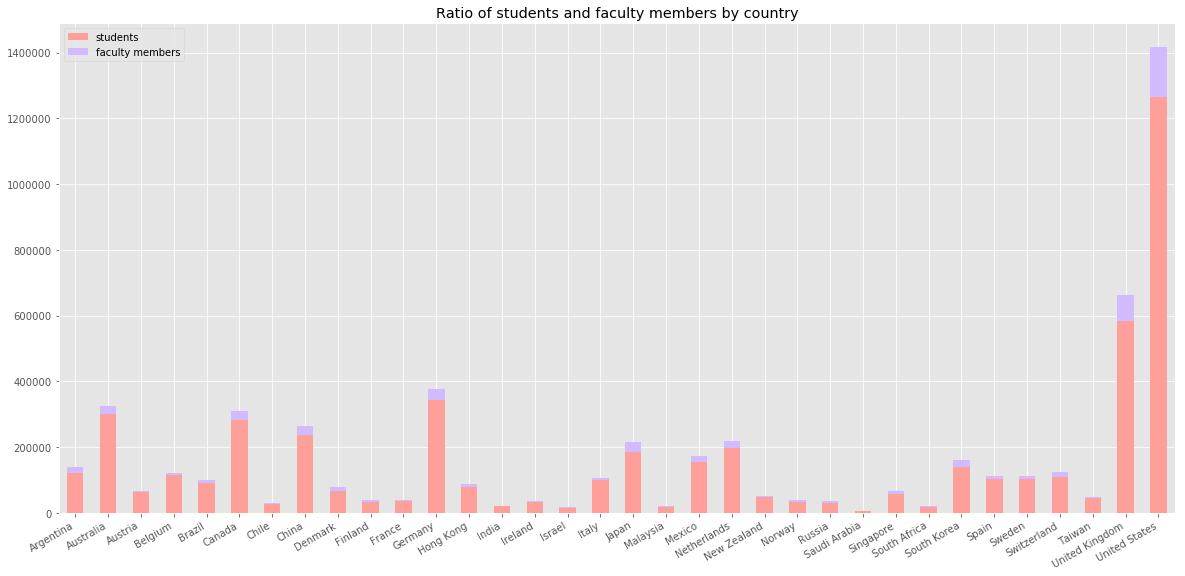

In [188]:
ratio_country = universities.groupby(['location'])['students_total', 'faculty_total'].sum()
ratio_country.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(20,10), sharey=True)
ratio_country.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by country')
axes.legend(labels=['students', 'faculty members'])
fig.autofmt_xdate()
plt.show()

**Comments:** We see that it is rather difficult to compare the ratios of the different countries. This is due to the different sizes of the population. In order to draw more precise information about it, we need to normalize the data with repect to each country.

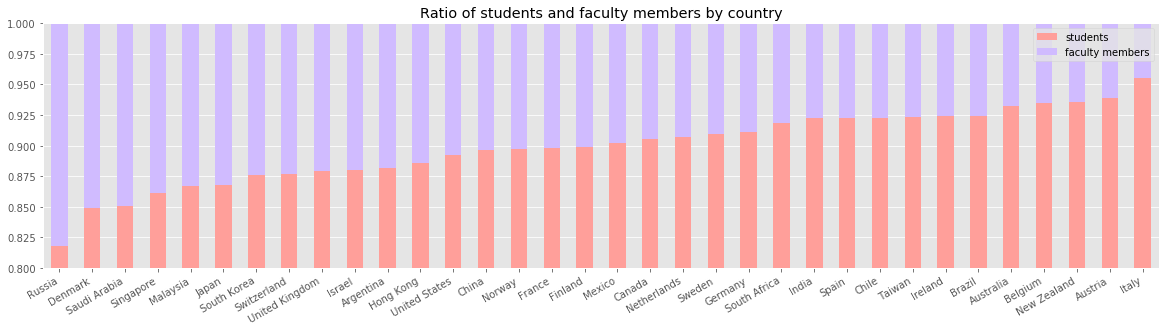

In [189]:
# normalize the data to be able to make a good comparison
ratio_country_normed = ratio_country.div(ratio_country.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
ratio_country_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(20, 5))
ratio_country_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by country')
axes.legend(labels=['students', 'faculty members'])
# we can restrict the range on the y axis to avoid displaying unnecessary content
axes.set_ylim([0.8,1])
fig.autofmt_xdate()
plt.show()

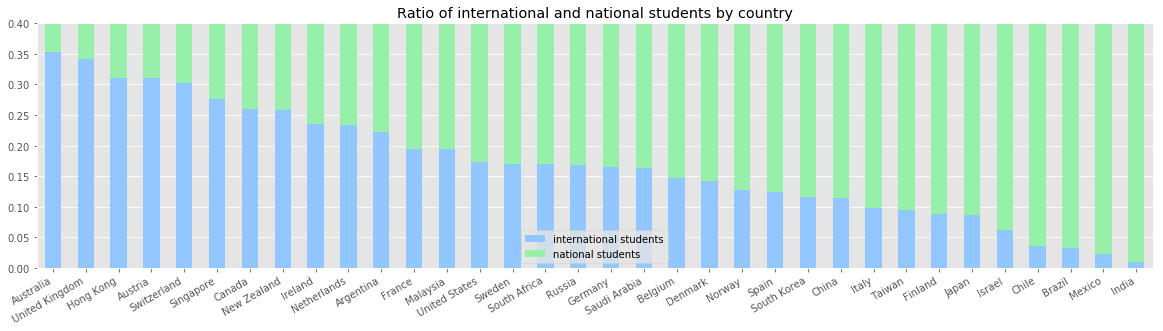

In [190]:
students_country = universities.groupby(['location'])['students_international', 'students_national'].sum()
students_country_normed = students_country.div(students_country.sum(1), axis=0).sort_values(by='students_international', ascending=False)
students_country_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(20, 5))
students_country_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Ratio of international and national students by country')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0, 0.4])
fig.autofmt_xdate()
plt.show()

**Comments**: Aggregating the data by country, we see that Russia is the country offering more faculty members for its student, followed by Danemark and Saudi Arabia. The most international university in terms of students is Australia, followed by United Kingdom and Hong Kong. Switzerland is in the fourth position and India is the country with the lowest ratio of international students.  

# By region

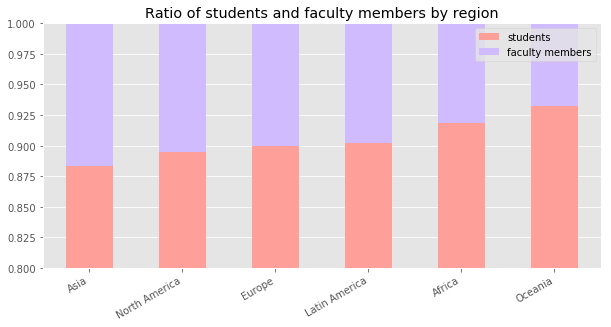

In [191]:
ratio_region = universities.groupby(['region'])['students_total', 'faculty_total'].sum()
ratio_region_normed = ratio_region.div(ratio_region.sum(1), axis=0).sort_values(by='faculty_total', ascending=False)
ratio_region_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ratio_region_normed.plot.bar(stacked=True, color=colors_1, ax=axes)
axes.set_title('Ratio of students and faculty members by region')
axes.legend(labels=['students', 'faculty members'])
axes.set_ylim([0.8,1])
axes.yaxis.grid(True)
fig.autofmt_xdate()
plt.show()

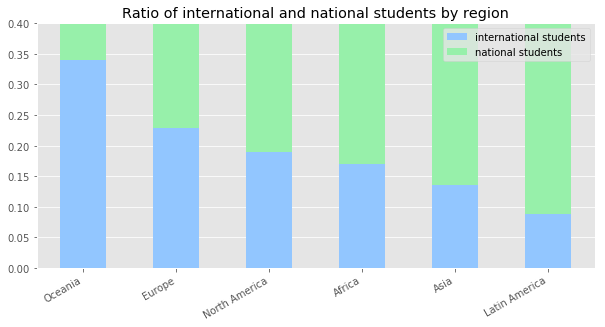

In [192]:
students_region = universities.groupby(['region'])['students_international', 'students_national'].sum()
students_region_normed = students_region.div(students_region.sum(1), axis=0).sort_values(by='students_international', ascending=False)
students_region_normed.index.name = None

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharey=True)
students_region_normed.plot.bar(stacked=True, color=colors_2, ax=axes)
axes.set_title('Ratio of international and national students by region')
axes.legend(labels=['international students', 'national students'])
axes.set_ylim([0,0.4])
axes.yaxis.grid(True)
fig.autofmt_xdate()
plt.show()

**Comments:** Asia is the region offering more faculty members to its students. It is followed by North America and Europe. The most international university in terms of students is Oceania. Europe is second.

### Analysis of the two methods

We get consistent results comparing the results obtained by region or by country about the ratio of international students. By country, we get Australia and by region, Oceania. This makes sense as Australia owns nine of the eleven universities of Oceania. 